# 2023 전력사용량 예측 AI 경진대회

In [1]:
# 라이브러리 호출
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 데이터 전처리

In [2]:
building_info = pd.read_csv('train_dataset/building_info.csv')
train = pd.read_csv('train_dataset/train.csv')

In [3]:
building_info

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,-,-,-
96,97,호텔및리조트,55144.67,25880.00,-,-,-
97,98,호텔및리조트,53578.62,17373.75,-,-,-
98,99,호텔및리조트,53499.00,40636.00,-,-,-


In [4]:
building_info.drop('태양광용량(kW)', axis=1, inplace=True)
building_info.drop('PCS용량(kW)', axis=1, inplace=True)
building_info.drop('ESS저장용량(kWh)', axis=1, inplace=True)
building_info.columns = ['num', 'type', 'Area', 'CoolingArea']

In [5]:
building_info

,num,type,Area,CoolingArea
0,1,건물기타,110634.00,39570.00
1,2,건물기타,122233.47,99000.00
2,3,건물기타,171243.00,113950.00
3,4,건물기타,74312.98,34419.62
4,5,건물기타,205884.00,150000.00
...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00
96,97,호텔및리조트,55144.67,25880.00
97,98,호텔및리조트,53578.62,17373.75
98,99,호텔및리조트,53499.00,40636.00


In [6]:
types = sorted(list(set(building_info['type'])))
types = {i:e for e, i in enumerate(types)}
types

{'건물기타': 0,
 '공공': 1,
 '대학교': 2,
 '데이터센터': 3,
 '백화점및아울렛': 4,
 '병원': 5,
 '상용': 6,
 '아파트': 7,
 '연구소': 8,
 '지식산업센터': 9,
 '할인마트': 10,
 '호텔및리조트': 11}

In [7]:
for i in range(len(building_info)):
    building_info.loc[i, 'type'] = types[building_info.loc[i, 'type']]

In [8]:
building_info

,num,type,Area,CoolingArea
0,1,0,110634.00,39570.00
1,2,0,122233.47,99000.00
2,3,0,171243.00,113950.00
3,4,0,74312.98,34419.62
4,5,0,205884.00,150000.00
...,...,...,...,...
95,96,11,93314.00,60500.00
96,97,11,55144.67,25880.00
97,98,11,53578.62,17373.75
98,99,11,53499.00,40636.00


In [9]:
train['num_date_time'] = [int(train.loc[i, 'num_date_time'][-2:]) for i in range(len(train))]

In [10]:
train.drop(labels='일시', axis=1, inplace=True)

In [11]:
train.columns = ['time', 'building_num', 'Temperature', 'rain(mm)', 'wind', 'humidity', 'sunshine(hr)', 'insolation(hr)', 'electricity']

In [12]:
train

,time,building_num,Temperature,rain(mm),wind,humidity,sunshine(hr),insolation(hr),electricity
0,0,1,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1,1,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,2,1,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,3,1,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,4,1,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...
203995,19,100,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,20,100,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,21,100,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,22,100,21.0,NaN,0.3,94.0,NaN,NaN,640.08


In [13]:
train['Area'] = [0] * len(train)
train['CoolingArea'] = [0] * len(train)
train['type'] = [0] * len(train)
for i in range(len(train)):
    train.loc[i, 'Area'] = building_info.loc[train.loc[i, 'building_num'] - 1, 'Area']
    train.loc[i, 'CoolingArea'] = building_info.loc[train.loc[i, 'building_num'] - 1, 'CoolingArea']
    train.loc[i, 'type'] = building_info.loc[train.loc[i, 'building_num'] - 1, 'type']

In [14]:
train.drop(labels='rain(mm)', axis=1, inplace=True)
train.drop(labels='sunshine(hr)', axis=1, inplace=True)
train.drop(labels='insolation(hr)', axis=1, inplace=True)

In [15]:
train

,time,building_num,Temperature,wind,humidity,electricity,Area,CoolingArea,type
0,0,1,18.6,0.9,42.0,1085.28,110634.00,39570.00,0
1,1,1,18.0,1.1,45.0,1047.36,110634.00,39570.00,0
2,2,1,17.7,1.5,45.0,974.88,110634.00,39570.00,0
3,3,1,16.7,1.4,48.0,953.76,110634.00,39570.00,0
4,4,1,18.4,2.8,43.0,986.40,110634.00,39570.00,0
...,...,...,...,...,...,...,...,...,...
203995,19,100,23.1,0.9,86.0,881.04,57497.84,40035.23,11
203996,20,100,22.4,1.3,86.0,798.96,57497.84,40035.23,11
203997,21,100,21.3,1.0,92.0,825.12,57497.84,40035.23,11
203998,22,100,21.0,0.3,94.0,640.08,57497.84,40035.23,11


In [16]:
train.dropna(inplace=True)

### 각 특성 간의 상관관계 파악

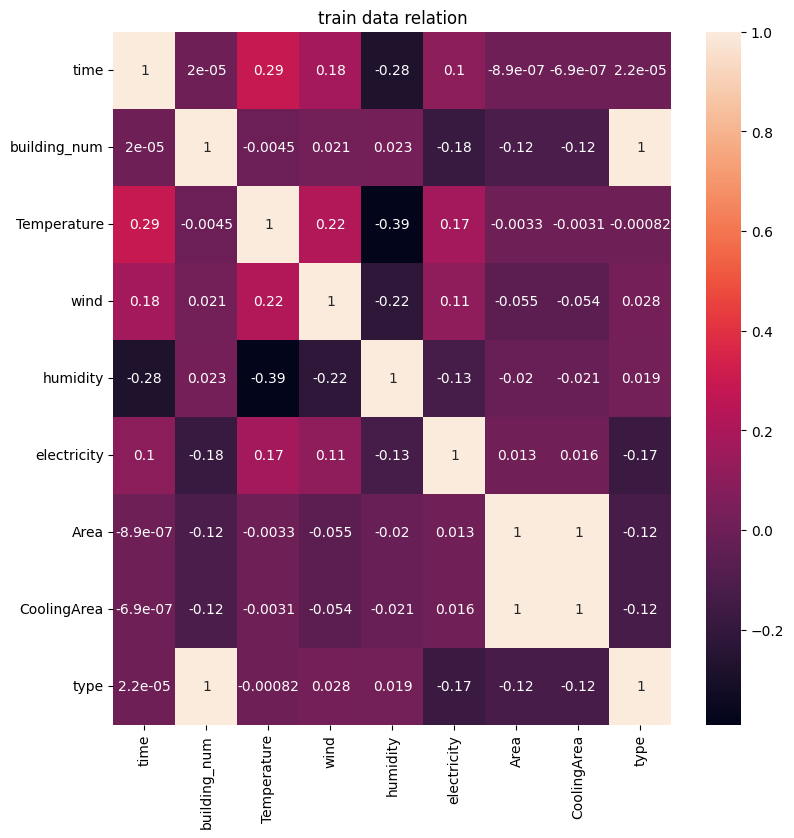

In [20]:
fig, ax = plt.subplots(figsize=(9,9))

sns.heatmap(train.corr(), annot=True, ax=ax)

plt.title('train data relation')
plt.show()

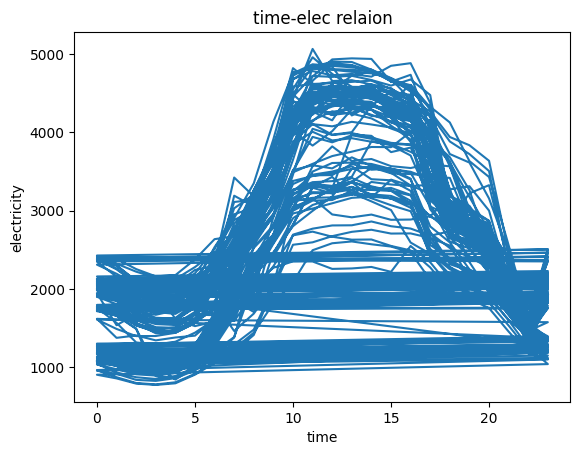

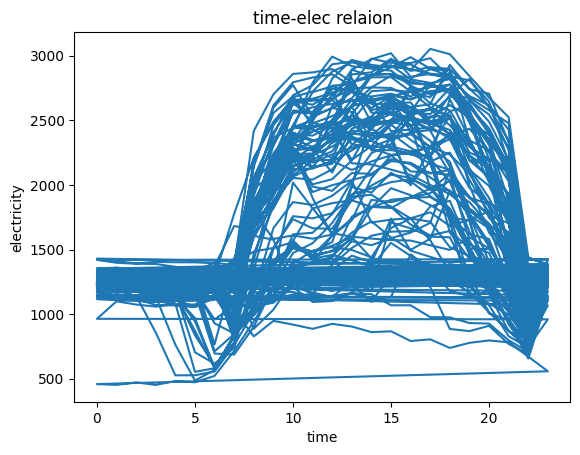

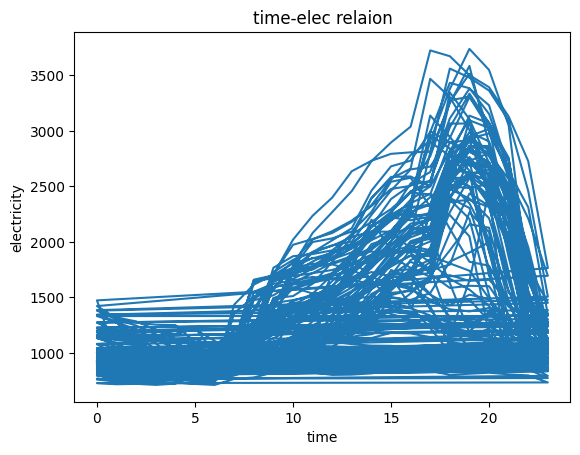

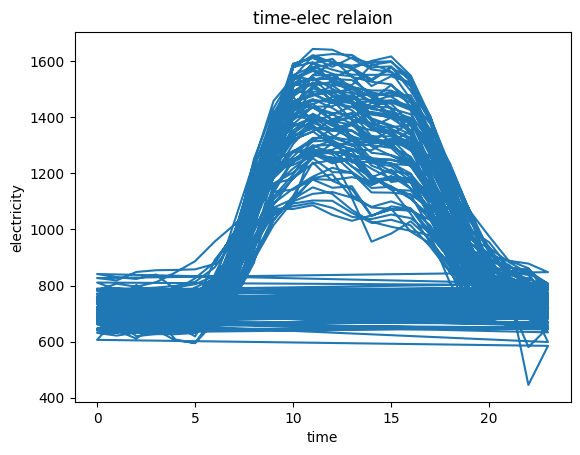

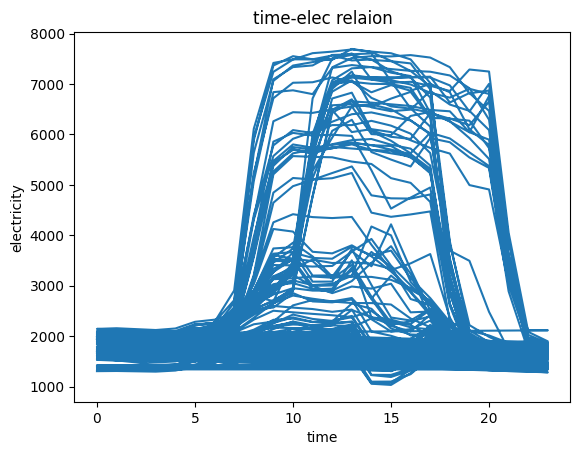

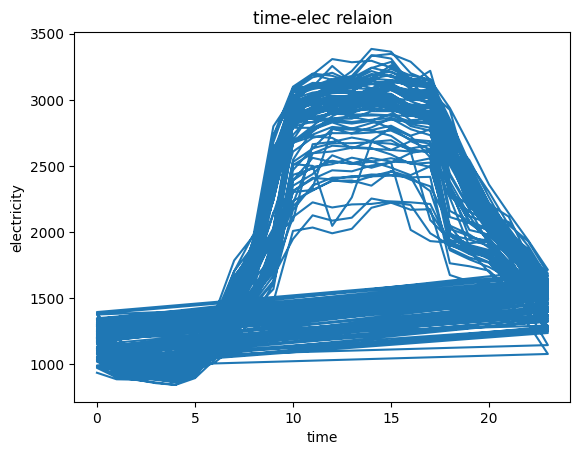

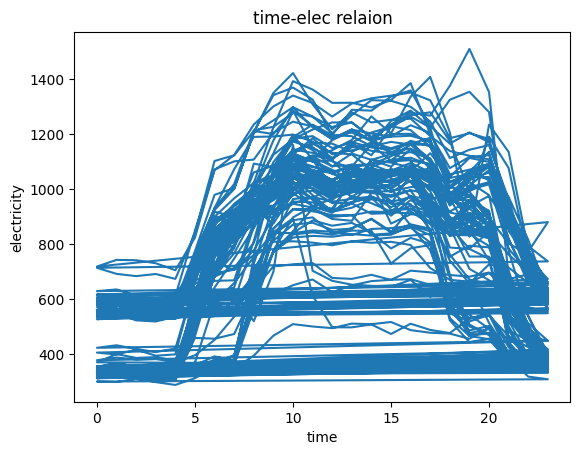

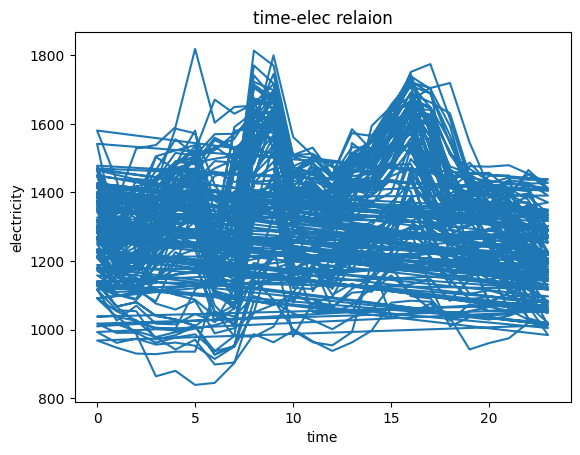

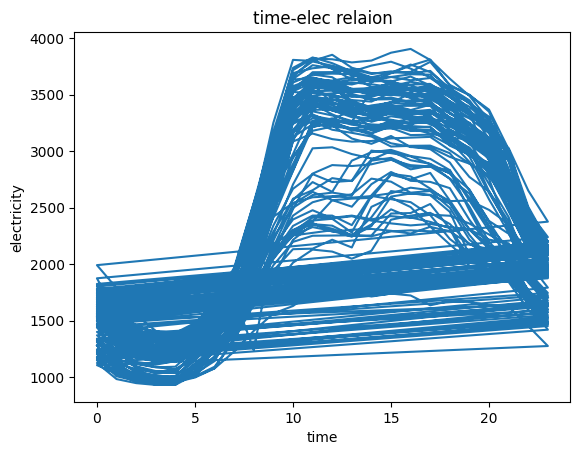

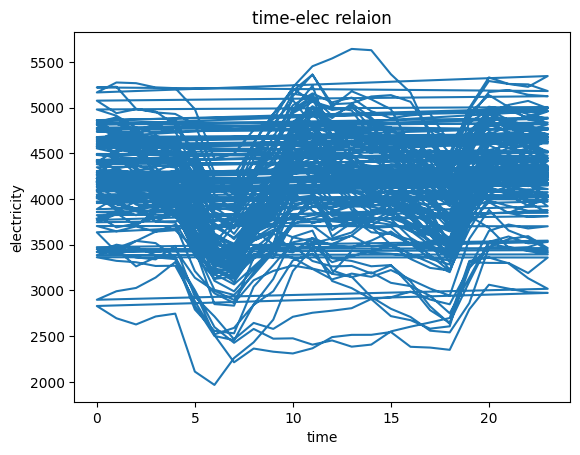

In [21]:
for i in range(1, 11):
    plt.plot(train[train['building_num']==i]['time'], train[train['building_num']==i]['electricity'])
    plt.xlabel('time')
    plt.ylabel('electricity')
    plt.title('time-elec relaion')
    plt.show()

### 건물별로 데이터 분리

In [17]:
timeScale = StandardScaler().fit(np.array(train['time']).reshape(-1,1))
windScale = StandardScaler().fit(np.array(train['wind']).reshape(-1,1))
TemperatureScale = StandardScaler().fit(np.array(train['Temperature']).reshape(-1,1))
humidityScale = StandardScaler().fit(np.array(train['humidity']).reshape(-1,1))
electricityScale = StandardScaler().fit(np.array(train['electricity']).reshape(-1,1))
AreaScale = StandardScaler().fit(np.array(train['Area']).reshape(-1, 1))
CoolingAreaScale = StandardScaler().fit(np.array(train['Area']).reshape(-1, 1))
typeScale = StandardScaler().fit(np.array(train['type']).reshape(-1, 1))

In [18]:
for i in range(1, 101):
    exec(f'train{i} = train[train["building_num"]=={i}]')

### 데이터 정규화

In [19]:
for i in range(1, 101):
    for col in ['time', 'wind', 'Temperature', 'humidity', 'electricity', 'Area', 'CoolingArea', 'type']:
        exec(f'train{i}[col] = {col}Scale.transform(np.array(train{i}[col]).reshape(-1, 1))')

<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

### 학습, 검증 데이터 분리

In [20]:
for i in range(1, 101):
    exec(f"train{i}_x, test{i}_x, train{i}_y, test{i}_y = train_test_split(\
         train{i}[['time', 'wind', 'Temperature', 'humidity', 'Area', 'CoolingArea', 'type']],\
            train{i}['electricity'], test_size=0.2, shuffle=False)")

### 데이터 병합

In [21]:
train_x = pd.concat([eval(f'train{i}_x') for i in range(1, 101)])
train_y = pd.concat([eval(f'train{i}_y') for i in range(1, 101)])
test_x = pd.concat([eval(f'test{i}_x') for i in range(1, 101)])
test_y = pd.concat([eval(f'test{i}_y') for i in range(1, 101)])

In [22]:
test_y

1632     -0.010301
1633     -0.027804
1634     -0.081297
1635     -0.119253
1636     -0.112959
            ...   
203995   -0.643262
203996   -0.676891
203997   -0.666173
203998   -0.741986
203999   -0.782892
Name: electricity, Length: 40799, dtype: float64

### window 처리
- https://blog.naver.com/sunghyeon98/222459222648
- https://youtu.be/NUMzrqxQ4zk

In [23]:
WINDOW_SIZE = 5
BATCH_SIZE = 10

In [24]:
ds_train_x = tf.data.Dataset.from_tensor_slices(train_x)
ds_train_x = ds_train_x.window(WINDOW_SIZE, stride=1, shift=1, drop_remainder=True)
ds_train_x = ds_train_x.flat_map(lambda x: x.batch(WINDOW_SIZE))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [25]:
ds_train_y = tf.data.Dataset.from_tensor_slices(train_y)

In [26]:
ds_test_x = tf.data.Dataset.from_tensor_slices(test_x)
ds_test_x = ds_test_x.window(WINDOW_SIZE, stride=1, shift=1, drop_remainder=True)
ds_test_x = ds_test_x.flat_map(lambda x: x.batch(WINDOW_SIZE))
ds_test_y = tf.data.Dataset.from_tensor_slices(test_y)

In [27]:
def windowed_dataset(x, y, window_size, batch_size, shuffle=False):
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda w: w.batch(window_size))

    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [28]:
train_dataset = windowed_dataset(train_x, train_y, WINDOW_SIZE, BATCH_SIZE)
test_dataset = windowed_dataset(test_x, test_y, WINDOW_SIZE, BATCH_SIZE)

In [29]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

## 모델 설계

In [30]:
Input = tf.keras.Input(shape=[WINDOW_SIZE, 7], name='Input')
LSTM_layer = tf.keras.layers.LSTM(units=64, return_sequences=True)(Input)
LSTM_layer1 = tf.keras.layers.LSTM(units=32, return_sequences=True)(LSTM_layer)
LSTM_layer2 = tf.keras.layers.LSTM(units=16, return_sequences=False)(LSTM_layer1)
dense4 = tf.keras.layers.Dense(units=1, activation='sigmoid')(LSTM_layer)
LSTMModel = tf.keras.Model(inputs=[Input], outputs=dense4, name='LSTMModel')

In [31]:
LSTMModel.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mse'])
StpCp = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
chkPoint = tf.keras.callbacks.ModelCheckpoint('models/', save_weights_only=True, save_best_only=True, monitor='val_loss')
history = LSTMModel.fit(train_dataset, epochs=100, steps_per_epoch=1000, validation_data=test_dataset, callbacks=[chkPoint, StpCp])

Epoch 1/100


1000/1000 [==============================] - 46s 42ms/step - loss: 0.1477 - mse: 0.3063 - val_loss: 0.3862 - val_mse: 1.2484
Epoch 2/100
1000/1000 [==============================] - 37s 37ms/step - loss: 0.1238 - mse: 0.2476 - val_loss: 0.3806 - val_mse: 1.2396
Epoch 3/100
1000/1000 [==============================] - 36s 36ms/step - loss: 0.1147 - mse: 0.2295 - val_loss: 0.3794 - val_mse: 1.2401
Epoch 4/100
1000/1000 [==============================] - 37s 37ms/step - loss: 0.4845 - mse: 1.5997 - val_loss: 0.4937 - val_mse: 1.3259
Epoch 5/100
1000/1000 [==============================] - 37s 37ms/step - loss: 0.9230 - mse: 4.9898 - val_loss: 0.2830 - val_mse: 0.9123
Epoch 6/100
1000/1000 [==============================] - 36s 36ms/step - loss: 0.8139 - mse: 2.6998 - val_loss: 0.2856 - val_mse: 0.9154
Epoch 7/100
1000/1000 [==============================] - 37s 37ms/step - loss: 0.2173 - mse: 0.4384 - val_loss: 0.2836 - val_mse: 0.9115
Epoch 8/100
1000/1000 [==============================

In [32]:
LSTMModel.evaluate(test_dataset)

     12/Unknown - 0s 10ms/step - loss: 0.1244 - mse: 0.2487

4080/4080 [==============================] - 34s 8ms/step - loss: 0.2673 - mse: 0.8652


[0.2673499286174774, 0.865181565284729]

Saved Loss graph


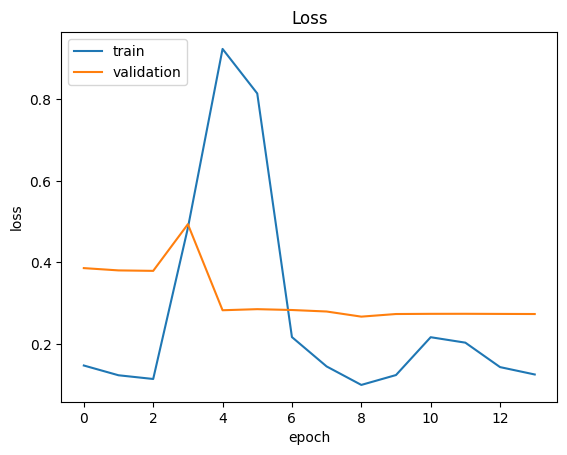

In [36]:
# Accuracy graph
# plt.figure(1)
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('Accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('ElecPredict_Accuracy_1.png')
# print("Saved Accuracy graph")

# Loss graph
plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('ElecPredict_Loss_1.png')
print("Saved Loss graph")

plt.show()

## 결과 파일 도출

In [47]:
test = pd.read_csv('test/ans.csv')
test['num_date_time'] = [int(test.loc[i, 'num_date_time'][-2:]) for i in range(len(test))]
test.drop(labels='일시', axis=1, inplace=True)
test.columns = ['time', 'building_num', 'Temperature', 'rain(mm)', 'wind', 'humidity']
test.drop(labels='rain(mm)', axis=1, inplace=True)
test


,time,building_num,Temperature,wind,humidity
0,19,1,25.5,2.9,63.0
1,20,1,25.0,2.6,66.0
2,21,1,24.6,1.3,67.0
3,22,1,24.1,2.1,70.0
4,23,1,23.8,1.4,70.0
...,...,...,...,...,...
16800,19,100,22.5,0.9,84.0
16801,20,100,20.7,0.4,95.0
16802,21,100,20.2,0.4,98.0
16803,22,100,20.1,1.1,97.0


In [48]:
test

,time,building_num,Temperature,wind,humidity
0,19,1,25.5,2.9,63.0
1,20,1,25.0,2.6,66.0
2,21,1,24.6,1.3,67.0
3,22,1,24.1,2.1,70.0
4,23,1,23.8,1.4,70.0
...,...,...,...,...,...
16800,19,100,22.5,0.9,84.0
16801,20,100,20.7,0.4,95.0
16802,21,100,20.2,0.4,98.0
16803,22,100,20.1,1.1,97.0


In [52]:
test['time'] = timeScale.transform(np.array(test['time']).reshape(-1,1))
test['Temperature'] = timeScale.transform(np.array(test['Temperature']).reshape(-1,1))
test['wind'] = timeScale.transform(np.array(test['wind']).reshape(-1,1))
test['humidity'] = timeScale.transform(np.array(test['humidity']).reshape(-1,1))
test['Area'] = AreaScale.transform(np.array([building_info.loc[test.loc[i, 'building_num'] - 1, 'Area'] for i in range(len(test))]).reshape(-1,1))
test['CoolingArea'] = CoolingAreaScale.transform(np.array([building_info.loc[test.loc[i, 'building_num'] - 1, 'CoolingArea'] for i in range(len(test))]).reshape(-1,1))
test['type'] = typeScale.transform(np.array([building_info.loc[test.loc[i, 'building_num'] - 1, 'type'] for i in range(len(test))]).reshape(-1, 1))

In [59]:
test.drop('building_num', axis=1, inplace=True)

In [60]:
test

,time,Temperature,wind,humidity,Area,CoolingArea,type
0,-1.932666,-1.929835,-1.939677,-1.913504,-0.117985,-0.173782,-1.424509
1,-1.932230,-1.930053,-1.939808,-1.912198,-0.117985,-0.173782,-1.424509
2,-1.931795,-1.930227,-1.940374,-1.911762,-0.117985,-0.173782,-1.424509
3,-1.931359,-1.930445,-1.940026,-1.910456,-0.117985,-0.173782,-1.424509
4,-1.930924,-1.930575,-1.940330,-1.910456,-0.117985,-0.173782,-1.424509
...,...,...,...,...,...,...,...
16800,-1.932666,-1.931142,-1.940548,-1.904359,-0.159706,-0.173417,1.594766
16801,-1.932230,-1.931925,-1.940766,-1.899569,-0.159706,-0.173417,1.594766
16802,-1.931795,-1.932143,-1.940766,-1.898262,-0.159706,-0.173417,1.594766
16803,-1.931359,-1.932187,-1.940461,-1.898698,-0.159706,-0.173417,1.594766


In [61]:
def windowed_dataset(x, window_size, batch_size, shuffle=False):
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda w: w.batch(window_size))
    if shuffle:
        ds_x = ds_x.shuffle(1000)
    return ds_x.batch(batch_size).prefetch(1)

In [62]:
ans = LSTMModel.predict(windowed_dataset(test, WINDOW_SIZE, BATCH_SIZE))

1681/1681 [==============================] - 12s 7ms/step


In [63]:
ans_tmp = [i[-1][0] for i in ans]

In [64]:
ans_tmp

[1.346402e-11,
 1.3462608e-11,
 1.3459372e-11,
 1.3453828e-11,
 1.3445131e-11,
 1.3430447e-11,
 1.3427731e-11,
 1.3424837e-11,
 1.34264e-11,
 1.3426169e-11,
 1.3427424e-11,
 1.3429806e-11,
 1.3433162e-11,
 1.3433571e-11,
 1.3433392e-11,
 1.3431932e-11,
 1.3447749e-11,
 1.3437955e-11,
 1.3435955e-11,
 1.34436715e-11,
 1.3449672e-11,
 1.34455684e-11,
 1.3444055e-11,
 1.3447826e-11,
 1.3446645e-11,
 1.3449107e-11,
 1.3443414e-11,
 1.3440594e-11,
 1.34321625e-11,
 1.3416338e-11,
 1.3418617e-11,
 1.3417823e-11,
 1.3417362e-11,
 1.3418207e-11,
 1.342453e-11,
 1.3426835e-11,
 1.3432316e-11,
 1.3440286e-11,
 1.3447826e-11,
 1.3453932e-11,
 1.34579604e-11,
 1.34600915e-11,
 1.346307e-11,
 1.34618375e-11,
 1.3460759e-11,
 1.3456446e-11,
 1.3454829e-11,
 1.3451468e-11,
 1.3448903e-11,
 1.3449032e-11,
 1.3444646e-11,
 1.3434186e-11,
 1.3427603e-11,
 1.3416313e-11,
 1.3417465e-11,
 1.3415545e-11,
 1.3416313e-11,
 1.3423839e-11,
 1.3433085e-11,
 1.34378775e-11,
 1.3446414e-11,
 1.3453084e-11,
 1.346

In [65]:
len(ans_tmp)

16801

In [66]:
ans_tmp = electricityScale.inverse_transform(np.array(ans_tmp).reshape(-1, 1))

In [67]:
ans_tmp

array([[2451.0623],
       [2451.0623],
       [2451.0623],
       ...,
       [2451.0623],
       [2451.0623],
       [2451.0623]], dtype=float32)

In [54]:
tmp = pd.read_csv('test/test.csv')

In [55]:
ans_df = pd.DataFrame()
ans_df['num_date_time'] = tmp['num_date_time']
ans_df['answer'] = ans[:-1]

ValueError: Length of values (4) does not match length of index (16800)

In [ ]:
ans_df

,num_date_time,answer
0,1_20220825 00,2451.062256
1,1_20220825 01,2451.062256
2,1_20220825 02,2451.062256
3,1_20220825 03,2451.062256
4,1_20220825 04,2451.062256
...,...,...
16795,100_20220831 19,2451.062256
16796,100_20220831 20,2451.062256
16797,100_20220831 21,2451.062256
16798,100_20220831 22,2451.062256


In [199]:
ans_df.to_csv('ans.csv', index=False)